<a href="https://colab.research.google.com/github/OzyMeister/Data-Analytics/blob/main/DA_Exp6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import string
from wordcloud import WordCloud
from collections import Counter

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

## Data Import and visualization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


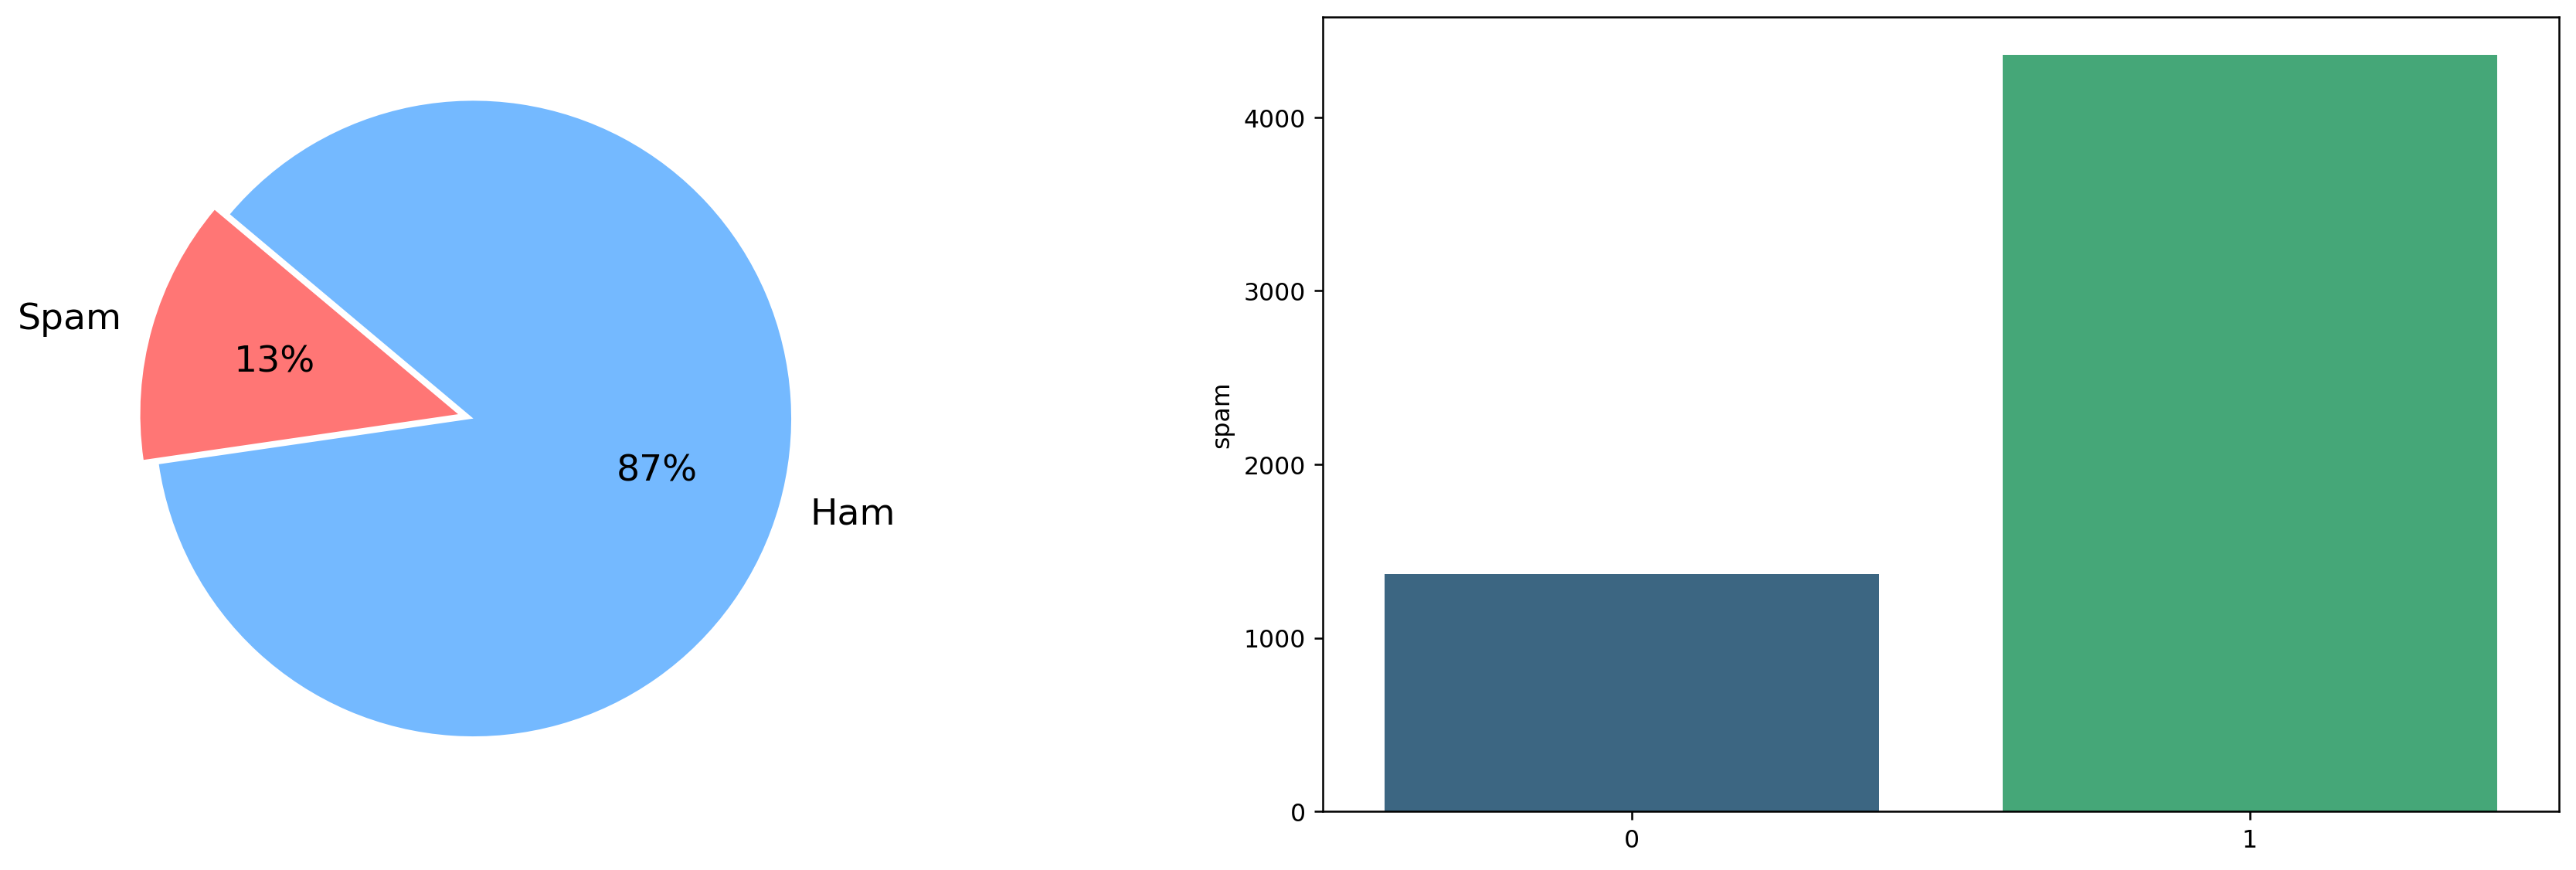

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# reading csv file and extracting class column to y.
data_set= pd.read_csv('https://mitocw.ups.edu.ec/courses/sloan-school-of-management/15-071-the-analytics-edge-spring-2017/text-analytics/assignment-5/emails.csv',encoding='utf-8')
data_set.head()
data_set.info()
data_set.shape
data_set['spam'].value_counts()
labels = ['Spam', 'Ham']
sizes = [747, 4825]
custom_colours = ['#ff7675', '#74b9ff']
plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140,
        autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])
plt.subplot(1, 2, 2)
sns.barplot(x = data_set['spam'].unique(), y = data_set['spam'].value_counts(), palette=
'viridis')
plt.show()

## Building Corpus

In [ ]:
data_set['Total Words'] = data_set['text'].apply(lambda x: len(x.split()))

In [ ]:
print("Spam categories",data_set[data_set['spam']==1].shape)
print("Ham Categories",data_set[data_set['spam']==0].shape)

Spam categories (1368, 3)
Ham Categories (4360, 3)


How many emails are in the dataset?
→ There are total of 5728 emails

How many of the emails are spam?
→ There are 1368 spams and 4360 hams

Which word appears at the beginning of every email in the dataset? Respond as a lower-case
word with punctuation removed
→ The dataset shows the word 'Subject' appears in the beginning of every email

Could a spam classifier potentially benefit from including the frequency of the word that
appears in every email?
→ If the term "subject" appears more frequently in spam emails than in ham emails, for example,
this may potentially help us distinguish between the two types of emails. If the word appears only
once in each mail, it won't help us distinguish.


## Preprocessing Text


1. Converting Data to lowercase
2. Removing any noise like ulrs, punctuations
3. Removing Stopwords
4. Stemming and Lemmatization



In [ ]:
def convert_lowercase(text):
    text = text.lower()
    return text

data_set['text'] = data_set['text'].apply(convert_lowercase)

def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data_set['text'] = data_set['text'].apply(remove_url)

exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data_set['text'] = data_set['text'].apply(remove_punc)

def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data_set['text'] = data_set['text'].apply(remove_stopwords)

def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data_set['text'] = data_set['text'].apply(perform_stemming)

**Performed preprocessing **

Converted to lowercase
Removed noise ie URLs and Punctiation and Stopwords(articles, prepositions, pronouns, conjunctions)

Stemming uses the stem of the word, while lemmatization uses the context in which the word is being used.

Stemming Caring -> Car

Lemmetization Caring -> Care

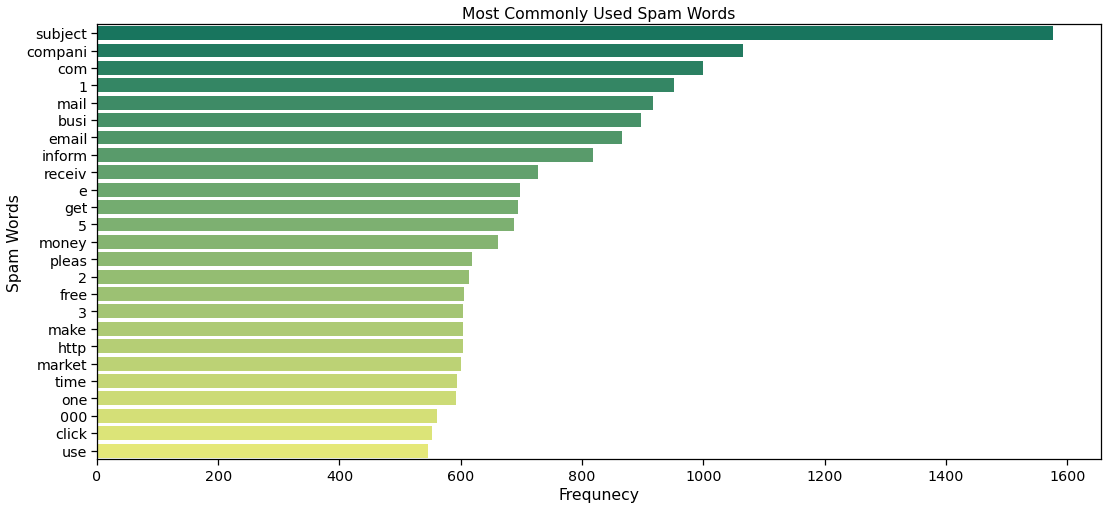

In [ ]:
def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char
data_set['Total Chars'] = data_set["text"].apply(count_total_words)
data_set.head()
all_spam_words = []
for sentence in data_set[data_set['spam'] == 1]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)
df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word','Frequency'])
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Spam Words")
plt.show()

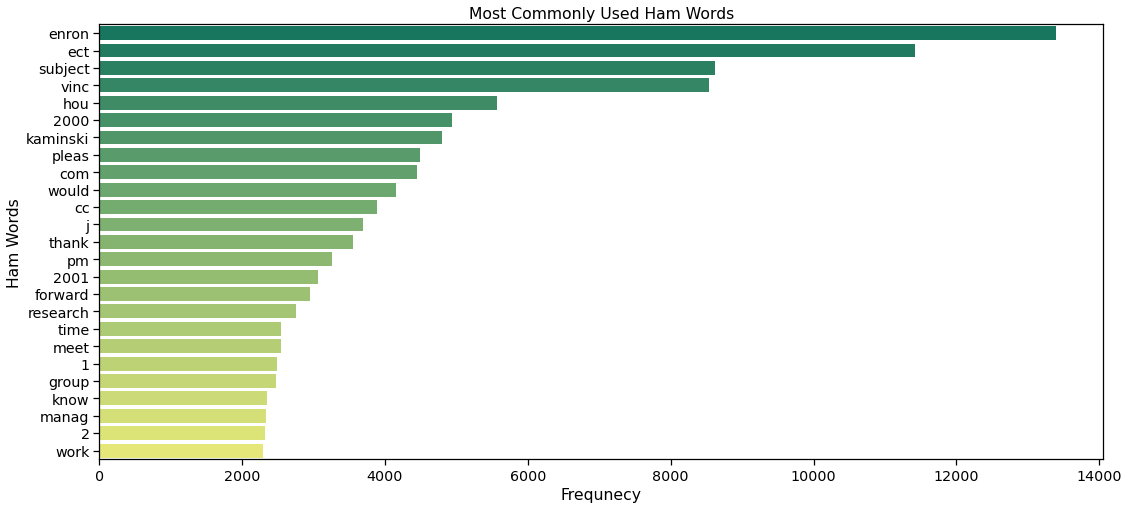

In [ ]:
all_ham_words = []
for sentence in data_set[data_set['spam'] == 0]['text'].to_list():
    for word in sentence.split():
        all_ham_words.append(word)
df = pd.DataFrame(Counter(all_ham_words).most_common(25), columns= ['Word','Frequency'])
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Ham Words")
plt.xlabel("Frequnecy")
plt.ylabel("Ham Words")
plt.show()

How many of the word stems "enron", "hou", "vinc", and "kaminski" appear in the CART
tree?

→ In the most frequently used Ham words, the words 'Vinc' and 'enron' appear and hence will be
used for Ham classification in case of CART algorithm.

## Creating Test and Train data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(data_set['text'], data_set['spam'],random_state=1)

cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b',lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Different Classifiers model training

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
spamNB = MultinomialNB()
spamNB.fit(X_train_cv, y_train)
 
# performing predictions on the test dataset
y_pred = spamNB.predict(X_test_cv)
y_prob = spamNB.predict_proba(X_test_cv)

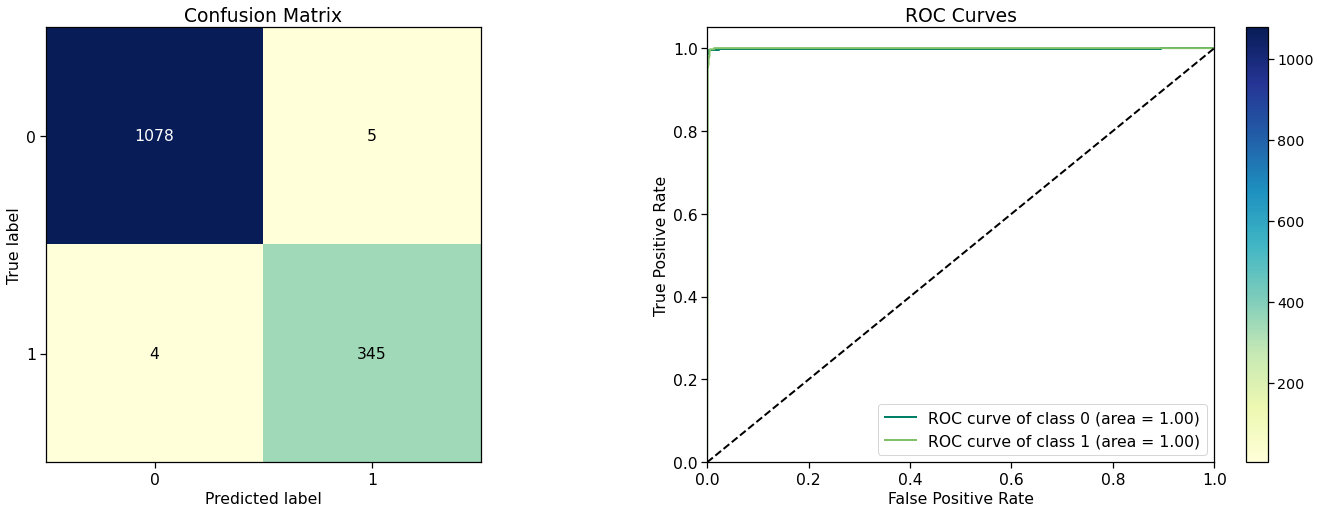

In [ ]:
from scikitplot.metrics import plot_confusion_matrix, plot_roc
fig, ax = plt.subplots(1, 2, figsize = (25,  8))
ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test,y_pred))
print("F1 score: ",f1_score(y_test, y_pred))

Accuracy score:  0.9937150837988827
Precision score:  0.9857142857142858
Recall score:  0.9885386819484241
F1 score:  0.9871244635193133


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
spamRF = RandomForestClassifier(n_estimators = 100) 
spamRF.fit(X_train_cv, y_train)
 
# performing predictions on the test dataset
y_pred = spamRF.predict(X_test_cv)
y_prob = spamRF.predict_proba(X_test_cv)

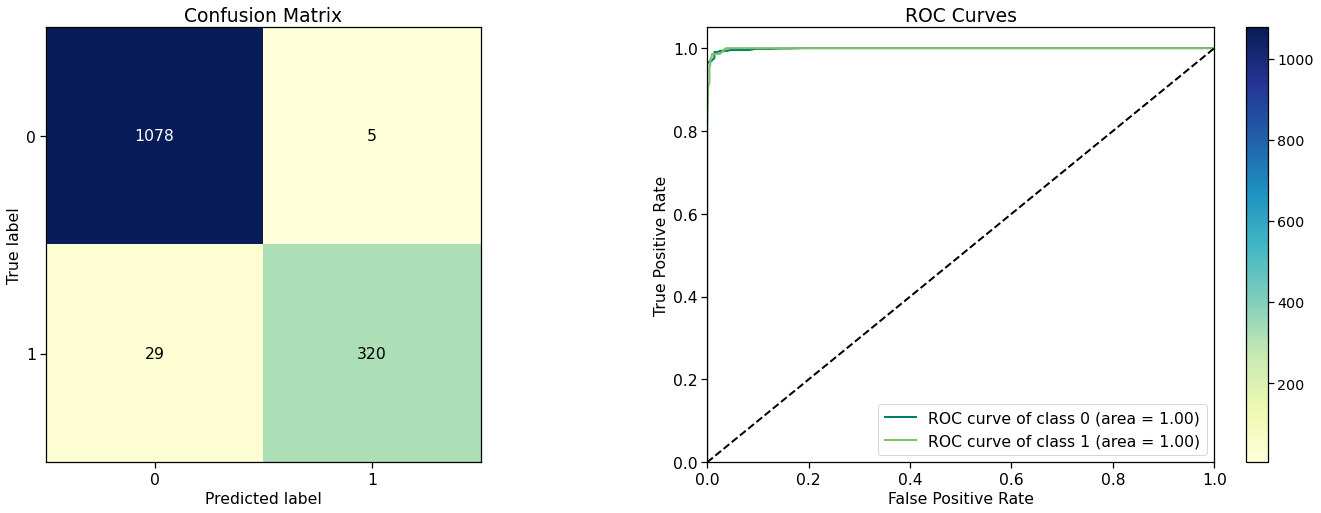

In [ ]:
from scikitplot.metrics import plot_confusion_matrix, plot_roc
fig, ax = plt.subplots(1, 2, figsize = (25,  8))
ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test,y_pred))
print("F1 score: ",f1_score(y_test, y_pred))

Accuracy score:  0.9762569832402235
Precision score:  0.9846153846153847
Recall score:  0.9169054441260746
F1 score:  0.9495548961424334


What is the training set AUC of spamRF?
→ Since we are using training data itself for testing accuracy, It will always be 100%

What is the testing set accuracy of spamRF?
→ Accuracy is 97.62%

What is the testing set AUC of spamRF?
→ The AUC for spamRF is 100%

### CART

In [ ]:
from sklearn.tree import DecisionTreeClassifier
spamCART = DecisionTreeClassifier(criterion = "entropy",
            random_state = 123,max_depth=10, min_samples_leaf=6)
  
# Performing training
spamCART.fit(X_train_cv, y_train)

# Prediction using gini
y_pred = spamCART.predict(X_test_cv)
y_prob = spamCART.predict_proba(X_test_cv)

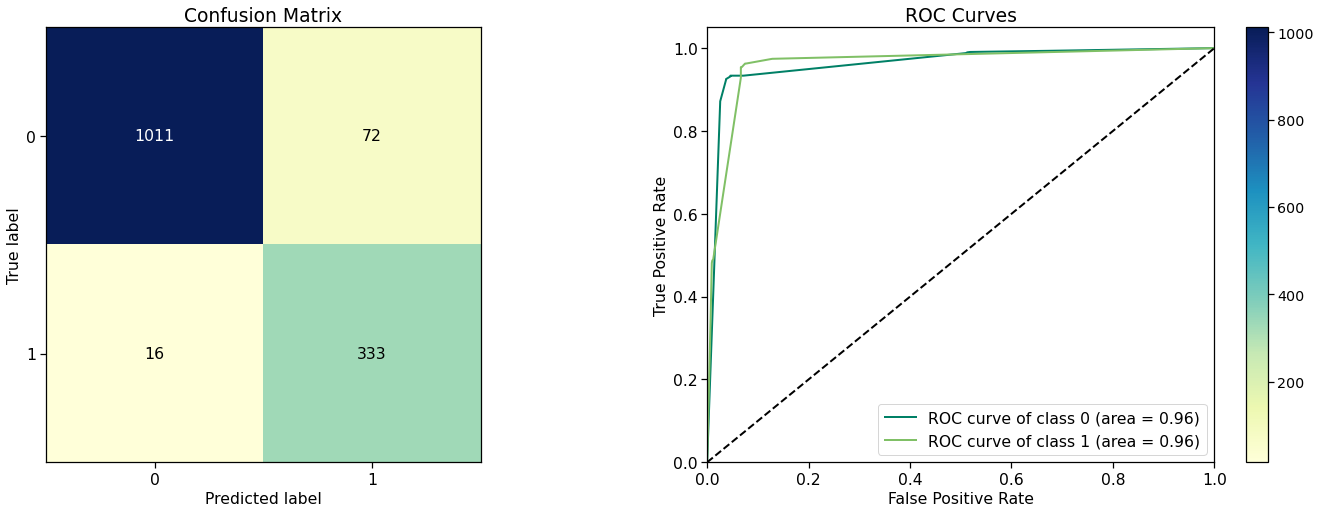

In [ ]:
from scikitplot.metrics import plot_confusion_matrix, plot_roc
fig, ax = plt.subplots(1, 2, figsize = (25,  8))
ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test,y_pred))
print("F1 score: ",f1_score(y_test, y_pred))

Accuracy score:  0.9385474860335196
Precision score:  0.8222222222222222
Recall score:  0.9541547277936963
F1 score:  0.883289124668435


What is the testing set accuracy of spamCART?
→ Accuracy is 93.85%

What is the testing set AUC of spamCART?
→ The AUC for spamCART is 96%

Which model had the best testing set performance, in terms of accuracy and AUC?
→ From the above accuracy results and AUC for two classifiers we can say that Random Forest is
better than CART

Conclusion:

● Data preprocessing is very important for training the model as any noise and irrelevant data can
hamper the model performance

● AUC gives a measure of separability for classes

● A good AUC score indicates good separability

● We can see that the training accuracy is 100% in both the models but the testing accuracy drops as this is the case where moel predict on the unseen data